In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from data_builder import *
from utils import *
%matplotlib inline

from data_builder import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
import argparse
import pickle
from model_builder import get_models

/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("-n_test_traj", '--ntesttraj', type=int, default=25)
parser.add_argument('-dt', '--dt', type=float, default=0.01)
parser.add_argument('-tmax', '--tmax', type=float, default=10.01)
parser.add_argument('-dname', '--dname', type=str, default='forced_mass_spring')
parser.add_argument('-noise_std', '--noise', type=float, default=0)
parser.add_argument('-type','--type',type=int,default=1)
args = parser.parse_args([])
n_test_traj = args.ntesttraj
T_max = args.tmax
T_max_t = args.tmax
dt = args.dt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
type_vec = args.type
num_samples_per_traj = int(np.ceil((T_max / dt))) - 1

if args.noise != 0:
    noisy = True
else:
    noisy = False

dataset_name = args.dname

# dataset preprocessing
valid_data = get_dataset(dataset_name, n_test_traj, T_max_t, dt, noise_std=0, seed=10,type=type_vec)
BS = num_samples_per_traj

vnow, vnext, venergy, vdx, vevals = nownext(valid_data, n_test_traj, T_max_t, dt, dt)


valdat = pendpixdata(vnow, vnext, venergy, vdx, vevals)
val_dataloader = DataLoader(valdat, batch_size=BS, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = { 'valid': []}

main_pred = {'baseline':[],'HNN':[],'TDHNN':[],'TDHNN1':[],'TDHNN2':[],'TDHNN3':[]}


def integrate_model(model, t_span, y0,t_eval, **kwargs):
    
    def fun(t, np_x):
        x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32).view(1,2)
        t = torch.tensor( t, requires_grad=True, dtype=torch.float32).view(1,1) 
        dx = model.time_deriv(x,t).data.numpy().reshape(-1)
        return dx

    return solve_ivp(fun=fun, t_span=t_span, y0=y0,t_eval=t_eval, **kwargs)

def test_model(model_name,model):
    # Each epoch has a training and validation phase
    for phase in ['valid']:
        for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict[phase]):
            q, q_next, qdx = q.float(), q_next.float(), qdx.float()
            q.to(device)
            q_next.to(device)
#                 energy_.to(device)
            qdx.to(device)
            tevals = tevals.float()
            tevals.to(device)
            loss = 0
            q.requires_grad = True
            tevals.requires_grad = True

            qinit = q[0].reshape(1, -1)

            preds = integrate_model(model,[0,T_max_t],qinit.detach().numpy().ravel(),t_eval=np.arange(0,T_max_t,dt)).y
#             preds = []
#             for i in range(len(q_next)):
#                 next_step_pred = model.next_step(qinit,tevals[i])
#                 preds.append(next_step_pred)
#                 qinit = next_step_pred

#             preds = torch.cat(preds).detach().numpy()
#             q_next = q_next.detach().numpy()

            main_pred[model_name].append(((preds.T)[:-1],q.detach().numpy()))


In [3]:
# model_ft = HNN(2, 200, 1, 0.01)
model_dct = get_models(dt, type=None, hidden_dim=200)
for model_name in model_dct.keys():
    print(model_name)
    model_type = torch.load(f'forced_mass_spring/{model_name}/model',map_location='cpu')
    model_type.eval()
    test_model(model_name,model_type)
    

TDHNN2


/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [4]:
model_type

TDHNN2(
  (mlp1): Linear(in_features=2, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=200, bias=True)
  (mlp3): Linear(in_features=200, out_features=200, bias=True)
  (mlp4): Linear(in_features=200, out_features=1, bias=False)
  (f1): Linear(in_features=1, out_features=200, bias=True)
  (f2): Linear(in_features=200, out_features=200, bias=True)
  (f2_): Linear(in_features=200, out_features=200, bias=True)
  (f3): Linear(in_features=200, out_features=1, bias=False)
)

In [5]:
def hamiltonian_fn(coords):
    q, p = coords[:,0],coords[:,1]
    t = np.arange(0,T_max_t,dt)[1:]
    K = (p ** 2) / 2 
    U = (q ** 2) / 2  # spring hamiltonian (linear oscillator)
    return K+U-q*np.sin(3*t)

In [6]:
np.arange(0,T_max_t,dt).shape

(1001,)

In [7]:
avg_perf = {}
for model in model_dct.keys():
    vals = main_pred[model]
    err=0
    for i in range(len(vals)):
        pred = vals[i][0]
        true = vals[i][1]
        err += np.mean(np.square(pred-true))
    err = err/len(vals)
    print(f'{model}:{err}')
    avg_perf[model] = err

TDHNN2:5.4634928493157914e-05


In [8]:
avg_perf.values

<function dict.values>

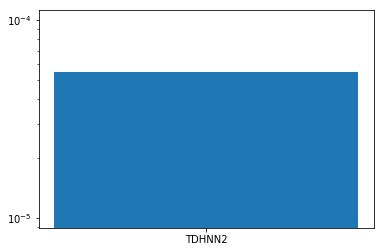

In [9]:
plt.bar(list(avg_perf.keys()),list(avg_perf.values()))
plt.yscale('log')

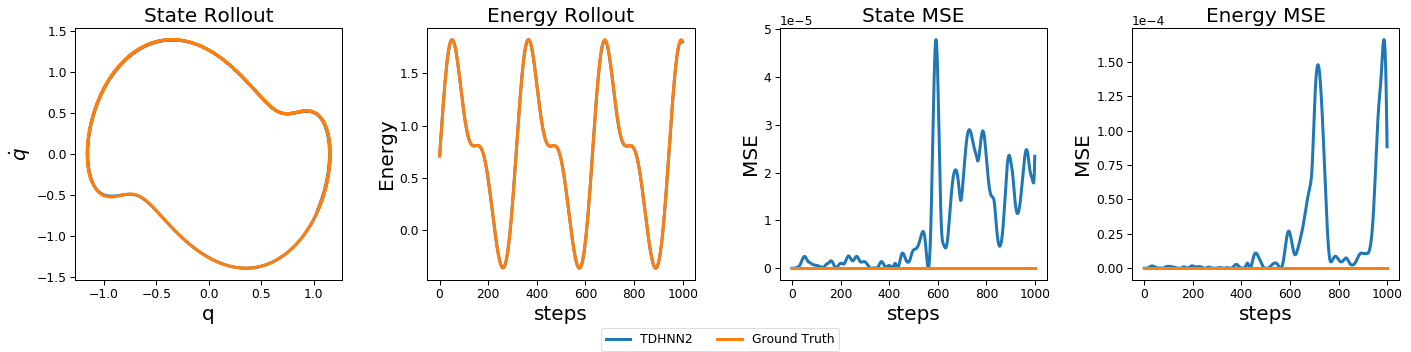

In [10]:
sns.axes_style(style='ticks')
sns.set_context("paper",font_scale=1.4, rc={'figure.figsize':(5,5),"font.size":20,"axes.titlesize":20,"axes.labelsize":20,'lines.linewidth':3})

lab_list = list(model_dct.keys())
fig,axs = plt.subplots(1,4,figsize=(5*4,5))
ax = axs.ravel()
#ax = axs.ravel()
# lab_list.remove('HNN')
for dex,name in enumerate(lab_list):
    yhat = main_pred[name][-3][0]#main_pred_coll[dex]
    true_batch = main_pred[name][-3][1]
                    
    K_pred = hamiltonian_fn(yhat)
    K_true = hamiltonian_fn(true_batch)
    ham_pred = K_pred 
    ham_true = K_true 
    
    ax[0].set_title('State Rollout')
    sns.lineplot(x=yhat[::,0],y=yhat[::,1],label=lab_list[dex],sort=False,ax=ax[0],legend=False)
    #ax[0].scatter(input_batch[:,0],input_batch[:,1])
    ax[0].set_xlabel('q')
    ax[0].set_ylabel(r'$\dot{q}$')


    ax[1].set_title('Energy Rollout')
    sns.lineplot(x=range(len(ham_pred)),y=ham_pred,label=lab_list[dex],ax=ax[1],legend=False)
    ax[1].set_xlabel('steps')
    ax[1].set_ylabel('Energy')



    ax[2].set_title('State MSE')
    l1 =sns.lineplot(x=range(len(yhat)),y=((yhat-true_batch)**2).mean(1),label=lab_list[dex],ax=ax[2],legend=False)
    ax[2].set_xlabel('steps')
    ax[2].set_ylabel('MSE')

    ax[3].set_title('Energy MSE')
    l2 =sns.lineplot(x=range(len(yhat)),y=(ham_pred-ham_true)**2,label=lab_list[dex],ax=ax[3],legend=False)
    ax[3].set_xlabel('steps')
    ax[3].set_ylabel('MSE')
    
sns.lineplot(x=true_batch[:,0],y=true_batch[:,1],markers='x',label='Ground Truth',ax=ax[0],sort=False,legend=False)
sns.lineplot(x=range(len(ham_pred)),y=ham_true,label='Ground Truth',ax=ax[1],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[2],legend=False)
sns.lineplot(x=range(len(yhat)),y=np.zeros(len(yhat)),label='Ground Truth',ax=ax[3],legend=False)
ax[2].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax[3].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# ax[1].set_yscale('log')
# ax[2].set_yscale('log')
handles, labels = ax[3].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center',bbox_to_anchor=(0.5, -0.015),fancybox=True,ncol=6)
#plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('mass_spring_long.pdf',dpi=2400,bbox_inches='tight')


In [11]:
for name, param in model_type.named_parameters():
    if param.requires_grad:
        print (name, param.data)

W tensor([[0.9595]])
mlp1.weight tensor([[ 0.0808,  0.1234],
        [-0.0705,  0.0635],
        [-0.1705,  0.1759],
        [-0.0483,  0.1012],
        [-0.1359, -0.0502],
        [-0.1068,  0.2055],
        [ 0.0285,  0.1239],
        [ 0.0852,  0.0701],
        [ 0.0676,  0.1280],
        [-0.0477, -0.0400],
        [-0.0668,  0.0274],
        [-0.1095,  0.0057],
        [ 0.0794,  0.0645],
        [-0.0693, -0.0348],
        [ 0.0623, -0.0068],
        [ 0.1652, -0.0552],
        [-0.1235,  0.0948],
        [ 0.0948, -0.1325],
        [-0.0666, -0.0077],
        [-0.1165,  0.0932],
        [-0.0484, -0.0591],
        [-0.0967, -0.0448],
        [-0.0843, -0.0901],
        [ 0.0148, -0.0485],
        [ 0.0555,  0.0694],
        [-0.0823,  0.1050],
        [ 0.0855, -0.0760],
        [-0.1086, -0.0373],
        [ 0.0585, -0.0154],
        [-0.1018,  0.1660],
        [ 0.0756, -0.1374],
        [-0.0476,  0.0416],
        [-0.1018,  0.0716],
        [-0.0532,  0.0940],
        [-0.156

In [12]:
torch.relu(torch.sigmoid(torch.tensor(0.9595)) - 0.5)

tensor(0.2230)

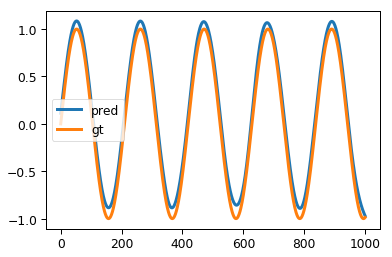

In [13]:
tevals = torch.arange(0,10.01,0.01)
tevals.to(device)
tevals.requires_grad = True
tevals = tevals.float()
f = model_type.get_F(tevals.reshape(-1,1))
plt.plot(-0.22*f.detach().numpy(),label='pred')
plt.plot(np.sin(3*tevals.detach().numpy()),label='gt')
plt.legend()

In [14]:
for batch_i, (q, q_next, energy_, qdx, tevals) in enumerate(data_dict['valid']):
    q=q.to(device)
    q=q.float()
    q.requires_grad=True
    tevals.to(device)
    tevals.requires_grad = True
    tevals = tevals.float()
    f = model_type.get_D(q[:,1].reshape(-1,1))
    plt.plot(0.062*f.detach().numpy())
    break

ModuleAttributeError: 'TDHNN2' object has no attribute 'get_D'

In [17]:
model_type = torch.load(f'forced_mass_spring/TDHNN2/model',map_location='cpu')
model_type.eval()
    

TDHNN2(
  (mlp1): Linear(in_features=2, out_features=200, bias=True)
  (mlp2): Linear(in_features=200, out_features=200, bias=True)
  (mlp3): Linear(in_features=200, out_features=200, bias=True)
  (mlp4): Linear(in_features=200, out_features=1, bias=False)
  (f1): Linear(in_features=1, out_features=200, bias=True)
  (f2): Linear(in_features=200, out_features=200, bias=True)
  (f2_): Linear(in_features=200, out_features=200, bias=True)
  (f3): Linear(in_features=200, out_features=1, bias=False)
)

In [18]:
for name, param in model_type.named_parameters():
    if param.requires_grad:
        print (name, param.data)

W tensor([[1.0065]])
mlp1.weight tensor([[-2.3201e-02, -1.8912e-01],
        [ 7.3593e-02, -4.8524e-02],
        [-4.6440e-02,  7.6749e-02],
        [-1.2162e-01,  1.2672e-01],
        [ 1.0579e-01, -1.0064e-01],
        [-1.1536e-01, -8.4962e-02],
        [-3.3154e-02, -5.5971e-02],
        [-2.3843e-02,  1.9794e-01],
        [ 7.0869e-02, -1.4502e-02],
        [-1.0230e-01, -1.3717e-01],
        [-5.4108e-02, -3.0996e-02],
        [ 1.2379e-01, -5.6190e-02],
        [ 1.9649e-02,  2.2949e-01],
        [ 3.3917e-02, -8.9749e-02],
        [-1.0816e-01, -7.0018e-02],
        [-1.2833e-01, -1.3151e-01],
        [-3.1310e-02, -1.5872e-01],
        [ 5.3049e-02,  1.4359e-01],
        [ 1.2687e-01,  1.2175e-01],
        [ 8.4238e-02, -2.2663e-02],
        [-1.1870e-02,  1.1972e-01],
        [-7.1252e-02, -6.7803e-02],
        [ 1.7340e-02, -1.0963e-01],
        [-1.1848e-02,  5.6040e-02],
        [-1.0310e-01, -7.4527e-02],
        [-7.8899e-02,  7.2310e-02],
        [-6.1207e-03,  4.9631e-

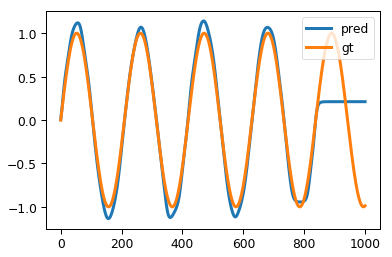

In [20]:
tevals = torch.arange(0,10.01,0.01)
tevals.to(device)
tevals.requires_grad = True
tevals = tevals.float()
f = model_type.get_F(tevals.reshape(-1,1))
plt.plot(-0.26*f.detach().numpy(),label='pred')
plt.plot(np.sin(3*tevals.detach().numpy()),label='gt')
plt.legend()